# BLU05 - Learning Notebook - Part 3 of 3 - Auto SARIMAX and Exogenous Features

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import itertools
import utils

plt.rcParams["figure.figsize"] = (10, 4.2)

Let's prepare our data again:

In [2]:
airlines = utils.load_airlines_series()
airlines = airlines.asfreq('MS')
airlines_logged = np.log(airlines)

In [3]:
train_log = airlines_logged.iloc[:-24]
test_log = airlines_logged.iloc[-24:]

## 1. pmdarima for auto-tuned models

### 1.1 Autotuning the SARIMAX hyperparameters

In the previous notebook we promised to show you how to get the best parameters for SARIMAX models. The time has come!

You may already suspect that the way to go is to train several models on the train set using different parameters and choose the one with the lowest AIC. And you are right! But, instead of doing it manually, we will use [pmdarima](http://alkaline-ml.com/pmdarima/), which is based on statsmodels. It not only automatises the SARIMAX model selection but also offers some extra functionality that we will see later on. 

In [4]:
import pmdarima as pm

We will use the [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima) class which automatically searches for the best SARIMAX model based on the train set. The SARIMAX model in pmdarima is represented by the [ARIMA](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html#pmdarima.arima.ARIMA) class which is a wrapper for the statsmodels [SARIMAX](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html#statsmodels.tsa.statespace.sarimax.SARIMAX) class.

`auto_arima` will first determine the order of differentiation, `d` and `D`, then search for the `p`/`P` and `q`/`Q` parameters within the specified limits. The default search procedure is not an exhaustive grid search, but rather an intelligent one. The search procedure is specified by the `stepwise` parameter, `True` by default. This [section](https://otexts.com/fpp3/arima-r.html) describes the search procedure in more detail.

We can let `auto_arima` search for all model parameters, but the search is faster if we specify some of them. We already know that the seasonality is of 12 periods, so we set `m=12`.

We can also specify the order of differentiation, either from examining the plot and plotting the ACF/PACF or by performing tests. We already know that some differentation is necessary. Let's see what the tests say.

Two test functions are available, for determining the normal and the seasonal differentation order. We input the train data and for the seasonal test also the seasonality.

In [5]:
pm.arima.ndiffs(train_log), pm.arima.nsdiffs(train_log,m=12) 

(1, 1)

Both of them suggest a first order differentiation. Let's take the suggestion and proceed with `auto_arima`.

The `trace` parameter set to `True` means that the fit outcomes will be printed out.

Technical note: we're feeding the model a numpy array instead of a pandas series this time. This is to avoid problems further down when we update the model. There is an inconsistency in the format of the forecasts which we'd like to avoid. This might be a temporary problem that resolves in future editions of pmdarima.

In [6]:
sarimax = pm.auto_arima(train_log.to_numpy(),trace=True,d=1,D=1,m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-383.352, Time=3.70 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-353.412, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-383.358, Time=0.49 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-389.010, Time=0.92 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-364.326, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-387.220, Time=1.25 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-387.254, Time=1.51 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-384.232, Time=2.31 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=10.36 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-379.989, Time=0.32 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-387.279, Time=1.53 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-387.065, Time=1.33 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-388.643, Time=0.54 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-385.329, Time=2.56 sec
 ARIMA(0,1,1)(0,1,1)[12

Ok, so this is how we can get the hyperparameters! These are not the same parameters that we used in the previous notebook, because, ehm, those were copied from the statsmodels documention, but nevermind, we'll see the how the two models compare. And the winner is: 

In [7]:
sarimax

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

You can run the search again with different starting parameters and compare the outcomes if you like. Just remember that comparing AIC is only possible for models with the same order of differentation because differentiation changes the scale of the data. If you want to evaluate models with different `d`/`D`, the comparison should be done on the forecasts.

There are several other [parameters](https://alkaline-ml.com/pmdarima/tips_and_tricks.html) that we can tune. A few of the important ones:
- `max_iter` controls the number of iterations on each test model, 50 by default, and can be useful to speed up the search.
- `method` choice can also speed up the search. For instance, the `nm` method is faster because it makes more approximations.
- `seasonal` defines if the model should have a seasonal component.
- `stepwise` can be set to `False` to perform an exhaustive grid search.

A cool thing about `pmdarima` is that it mimics the `sklearn`'s API (interface). So, how do you think we can get predictions and forecasts from the best found model? We simply use `predict_in_sample` and `predict`.

In [8]:
sarimax_prediction = sarimax.predict_in_sample()
sarimax_forecast = sarimax.predict(24)

Let's also check if the MAE is the same as with `statsmodels`:

In [9]:
(mean_absolute_error(np.exp(sarimax_prediction[13:]),np.exp(train_log[13:])), 
mean_absolute_error(np.exp(sarimax_forecast),np.exp(test_log)))

(7.384311954528291, 39.439927615877174)

Ok, all good, we got similar values as in the previous notebook.

### 1.2 Updating the pmdarima model
We saw that the statsmodels SARIMAX can be updated with new data using the _static_, _refit_ or _remake_ strategies. We'll see now how to do it with the pmdarima model.

`pmdarima` does not offer the _static_ option. The _refit_ strategy works via the `update` method which refits the model using the current fitted parameters as initial values. The _remake_ strategy corresponds to tuning the model again.

The following loop implements multiple one-step forecasts for the whole test set with the _refit_ strategy. It's basically the same code as in the previous notebook, just using different libraries.

In [10]:
sarimax_forecast_one_step_refit = []
for i in np.arange(0,24):
    next_step_forecast = sarimax.predict(1)[0]
    sarimax_forecast_one_step_refit.append(next_step_forecast)
    sarimax.update(test_log.iloc[i])

Let's take a look at the MAE:

In [11]:
mean_absolute_error(np.exp(sarimax_forecast_one_step_refit),np.exp(test_log))

11.57401716976137

This MAE is also looking good.

### 1.3 pmdarima pipelines
 `pmdarima` has [pipelines](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.pipeline.Pipeline.html#pmdarima.pipeline.Pipeline) similar to `sklearn`, making it easy to include a preprocessing step before the modeling. The classes used in the pipeline need to have the typical `sklearn` signature of `fit-transform-predict`, so we'll have to use [AutoARIMA](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.AutoARIMA.html) instead of `auto_arima`.

Remember in the first notebook when we mentioned that the `log` transformation is just a particular case of the `Box-Cox` transformation? We will use the Box-Cox now in the pipeline to find the best transformation to unskew our distribution. The pipeline is great for transformations because the predictions and forecasts are always automatically back-transformed.

If you need to recall what are pipelines before proceeding, head back to SLU16 and BLU02.

In [12]:
from pmdarima.pipeline import Pipeline
from pmdarima.arima import AutoARIMA
from pmdarima.preprocessing import BoxCoxEndogTransformer

Here we run the parameter search again, but this time with a pipeline which preprocesses the data with a `Box-Cox` instead of a `log`. First we need to prepare a new train and test set because the one we were using was logged.

In [13]:
train_pipeline = airlines.iloc[:-24]
test_pipeline = airlines.iloc[-24:]

Let's first see what the Box-Cox transform does to our data and compare it with the logged data.

In [14]:
boxcox = BoxCoxEndogTransformer()
train_boxcox, _ = boxcox.fit_transform(train_pipeline)

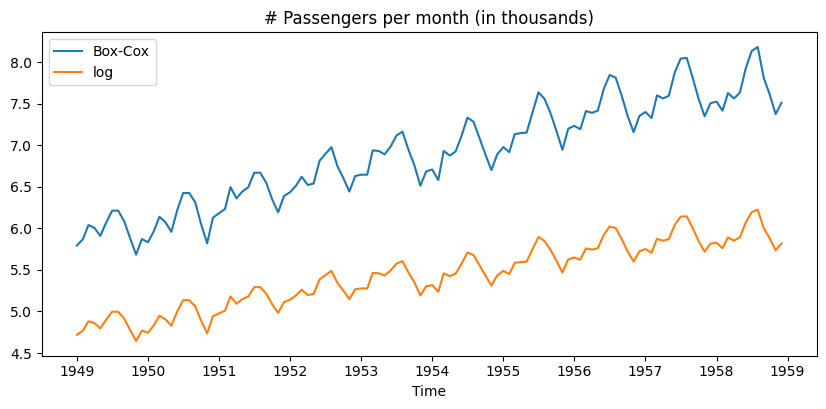

In [15]:
plt.plot(pd.Series(train_boxcox, index=train_log.index), label='Box-Cox')
plt.plot(train_log, label='log')
plt.xlabel('Time')
plt.title('# Passengers per month (in thousands)')
plt.legend();

The Box-Cox transform suppressed the unequal variance across the timeseries similarly to the log transformation. Both transformations also changed the distribution of the data to a more symmetrical one.

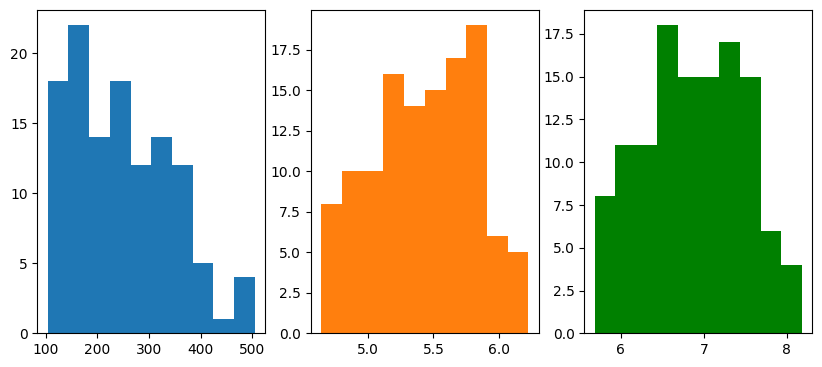

In [16]:
fig,ax=plt.subplots(1,3)
ax[0].hist(airlines.iloc[:-24], label='original')
ax[1].hist(train_log, label='log', color='tab:orange')
ax[2].hist(train_boxcox, label='Box-Cox', color='green');

Time for the pipeline!

In [17]:
sarimax_pipeline = Pipeline([
    ('boxcox', BoxCoxEndogTransformer()),
    ('arima', pm.AutoARIMA(trace=True,d=1,D=1,m=12))
])

sarimax_pipeline.fit(train_pipeline.to_numpy())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=-285.812, Time=2.16 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-258.569, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-287.046, Time=0.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-291.231, Time=0.62 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-269.163, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-289.481, Time=0.67 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.62 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-287.552, Time=0.60 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-287.436, Time=2.34 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-282.929, Time=0.28 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-289.149, Time=0.65 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-289.246, Time=1.16 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-291.149, Time=0.45 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-287.665, Time=1.95 sec
 ARIMA(0,1,1)(0,1,1)[12]

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer()),
                ('arima', AutoARIMA(D=1, d=1, m=12, trace=True))])

Ok, we got the same model as above. What about the MAE?

In [18]:
sarimax_pipeline_forecast = sarimax_pipeline.predict(24)

In [19]:
mean_absolute_error(sarimax_pipeline_forecast,test_pipeline)

42.760156459743484

Similar as before, everything's cool. Let's also plot both forecasts:

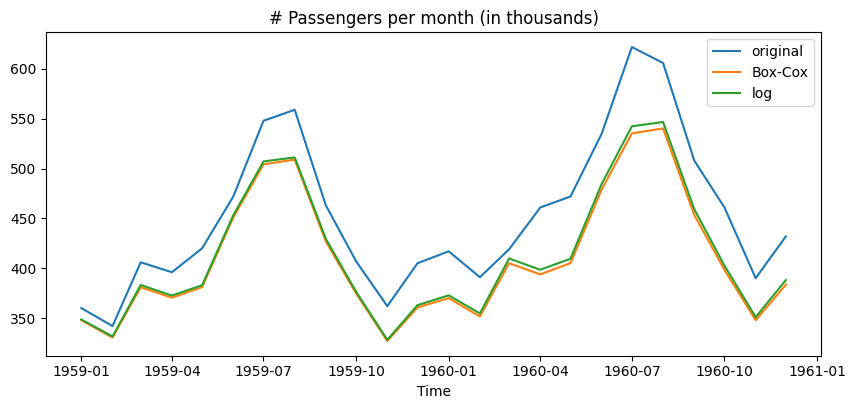

In [20]:
plt.plot(test_pipeline, label='original')
plt.plot(pd.Series(sarimax_pipeline_forecast, index=test_pipeline.index), label='Box-Cox')
plt.plot(pd.Series(np.exp(sarimax_forecast), index=test_pipeline.index), label='log');
plt.xlabel('Time')
plt.title('# Passengers per month (in thousands)')
plt.legend();

They're basically the same which was expected.

## 2. Exogenous variables in ARIMA models

You must already be tired of looking at yearly airline passengers on every plot. Let's test your new skills on a new dataset - hourly production of solar energy - and finally get to the X factor in SARIMAX.

We'll take the first half of January as the train set and the second half as the test set.

In [21]:
solar = utils.load_solar_data()
train_solar = solar.loc[:'2016-01-15']
test_solar = solar.loc['2016-01-16':'2016-01-31']

This is our data:

In [22]:
train_solar.head()

,Power
Datetime,
2016-01-01 07:00:00+00:00,0.000000
2016-01-01 08:00:00+00:00,641.772625
2016-01-01 09:00:00+00:00,4670.041125
2016-01-01 10:00:00+00:00,6864.839375
2016-01-01 11:00:00+00:00,6030.192250


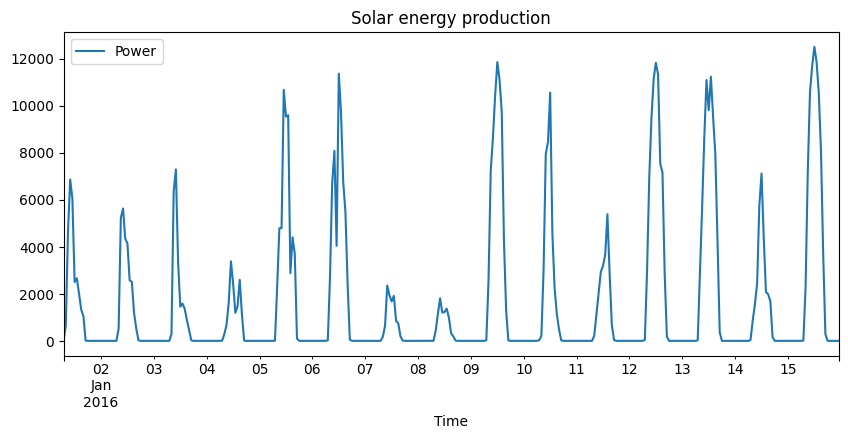

In [23]:
train_solar.plot()
plt.title('Solar energy production')
plt.xlabel('Time');

Not surprisigly, the data has a clear seasonality (the sun does not shine at night :) ). On the other hand, there doesn't seem to be any significant trend. The variance fluctuates, but without a clear pattern. Let's check the ACF and PACF plots to better understand the patterns in the data.

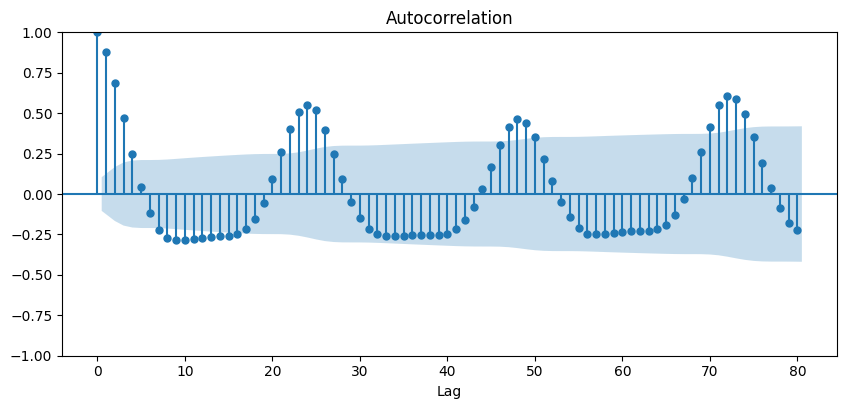

In [24]:
plot_acf(train_solar, alpha=.05, lags=80)  
plt.xlabel('Lag');

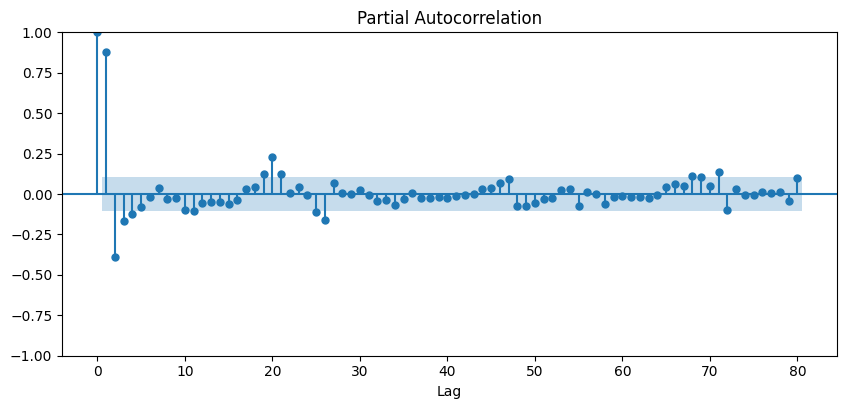

In [25]:
plot_pacf(train_solar, alpha=.05, lags=80)  
plt.xlabel('Lag');

The plots confirms a daily (24 hour) seasonality which makes sense given the day-night pattern (this is what we call domain knowledge, our understanding of the problem at hand).

We will not use the Box-Cox transform this time because the variance doesn't really change. We will set the seasonality to 24 and to make AutoARIMA run faster, we will use the `nm` method and lower the number of iterations.

In [26]:
sarimax_pipeline_solar = Pipeline([
    ('arima', pm.AutoARIMA(trace=True, m=24, method='nm', maxiter=10))
])

sarimax_pipeline_solar.fit(train_solar)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=19114.293, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=6682.597, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=6114.810, Time=0.85 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=6681.594, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=6772.928, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=6155.606, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=2.74 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=6142.830, Time=0.52 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=6153.382, Time=0.46 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=6107.467, Time=1.87 sec
 ARIMA(1,0,0)(2,0,2)[24] intercept   : AIC=6122.597, Time=2.83 sec
 ARIMA(1,0,0)(1,0,2)[24] intercept   : AIC=6143.325, Time=1.47 sec
 ARIMA(0,0,0)(2,0,1)[24] intercept   : AIC=6920.615, Time=1.33 sec
 ARIMA(2,0,0)(2,0,1)[24] intercept   : AIC=6175.446, Time=1.73 sec
 ARIMA(1,0,1)(2,0,1)[24

Pipeline(steps=[('arima',
                 AutoARIMA(m=24, maxiter=10, method='nm', trace=True))])

Time for in-sample predictions.

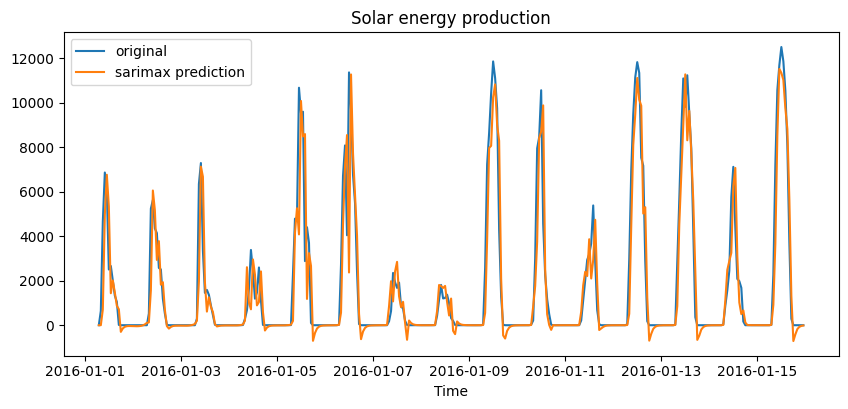

In [27]:
plt.plot(train_solar, label='original')
plt.plot(train_solar.index, sarimax_pipeline_solar.predict_in_sample(), label='sarimax prediction')
plt.xlabel('Time')
plt.title('Solar energy production')
plt.legend();

In [28]:
mean_absolute_error(sarimax_pipeline_solar.predict_in_sample()[25:],train_solar.iloc[25:])

603.74058381212

The model captured the seasonality quite well, but not so much the changing intra-day variance. Let's look at a 17-day multi-step forecast:

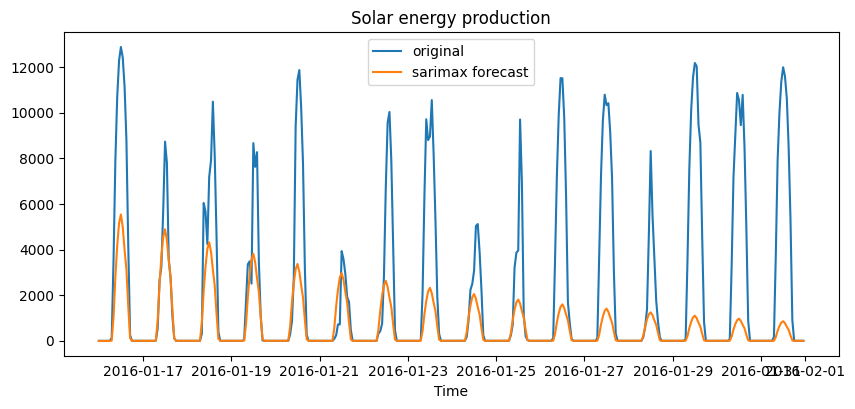

In [29]:
plt.plot(test_solar, label='original')
plt.plot(test_solar.index, sarimax_pipeline_solar.predict(test_solar.shape[0]), label='sarimax forecast')
plt.xlabel('Time')
plt.title('Solar energy production')
plt.legend();

In [30]:
mean_absolute_error(sarimax_pipeline_solar.predict(test_solar.shape[0]), test_solar)

1657.433294281858

The model clearly didn't capture any patterns which explain the changing variance throughout the timeseries. This means there's something missing in our model.

Can we add another input that will help the model do better? 

### 2.1 Exogenous variables

#### 2.1.1 Some bits of domain knowledge

Solar energy production depends mainly on the incoming sunlight (or solar radiation). Thus, when forecasting solar power production, the variable we really want to have is the solar radiation at the given moment. 

Ideally, we'd like to have the **forecast of the solar radiation**. Luckily, it is available from the weather forecast, same as wind speed, precipitation, etc. So, we can use someone else's model outputs to our advantage ;)

<img src="media/radiation_inputs.jpg" alt="Drawing" style="width: 350px;">

#### 2.1.2 Exogenous and endogenous Variables

External variables added to forecasting models are called **exogenous variables**. When you choose such variables for you model it is important to keep two things in mind:
- **independence** as, ideally, your exogenous input should be independent from your prediction;
- **causality** and the mantra "_Correlation does not imply causation_".

About the first point, imagine you have a model that predicts the price of a product based on (1) demand and (2) past price values. You might be tempted to think that (1) is exogenous. But economists know that if you lower the price of a good, people will tend to acquire more of it. So the demand is not independent of the predictions of your model, even more if you use those predictions to set the price. 

The second point was already discussed in SLU05, but if you don't remember, check the [spurious correlations website](https://www.tylervigen.com/spurious-correlations). If this really piques your interest, consider this [book reading suggestion](https://www.goodreads.com/book/show/36204378-the-book-of-why).

On other side of the variable spectrum, we have the past values of the solar energy production (or past prices in the price prediction example). These are the **endogenous variables**.

The definition of these concepts is not consensual, but a simplistic view is that past values of your target variable are **endogenous** and everything else is **exogenous**. A more complex one considers that any variable which depends on the forecast target is also **endogenous** (example for our case study: typical solar generators produce less the hotter they are, but they also get hotter the more they produce).

### 2.2 Regression with ARIMA errors

Remember the 'with exogenous regressors' part in the SARIMAX name? Now we'll explain that.

There are various ways how to extend the ARIMA models with exogenous variables. We will be using the formulation called regression with ARIMA errors which looks like this

$$y_t=\beta x_t+n_t$$

$$n_t=\phi_1 n_{t−1}+...+\phi_p n_{t−p}−\theta_1 z_{t−1}−...−\theta_q z_{t−q}+z_t$$

The first equation is a linear regression of the time series $y$ against the exogenous variable $x$ where $\beta$ is the model coefficient and $n_t$ are the residuals of the regression.

These residuals are the variable in the ARIMA model represented by the second equation.

Both parts of the model are optimized together by minimizing the $z_t$ error term which should become white noise.

A note about stationarity: for ARIMA models, we required a stationary time series. Here the part that we want to be stationary is $n_t$, the residuals of the regression which are fed to the ARIMA model. You can of course make both $y$ and $x$ stationary. In practice, if one of the variables needs to be transformed for stationarity, all the variables are transformed (you can have several exogenous variables).

Enough chitchat, let's (finally) get our hands dirty with SARIMAX.

Let's load a radiation forecast dataset. The index of this dataset are the dates for which the forecast was made. Usually, the forecast is produced one month ahead of time, so we can conveniently use it in our model.

In [31]:
exog = utils.load_solar_radiation_data()
exog_train = exog.loc[train_solar.index]
exog_test = exog.loc[test_solar.index]

In [32]:
exog_train.head()

,radiation
Datetime,
2016-01-01 07:00:00+00:00,176.404685
2016-01-01 08:00:00+00:00,4642.374645
2016-01-01 09:00:00+00:00,13736.716216
2016-01-01 10:00:00+00:00,22970.059760
2016-01-01 11:00:00+00:00,21095.601360


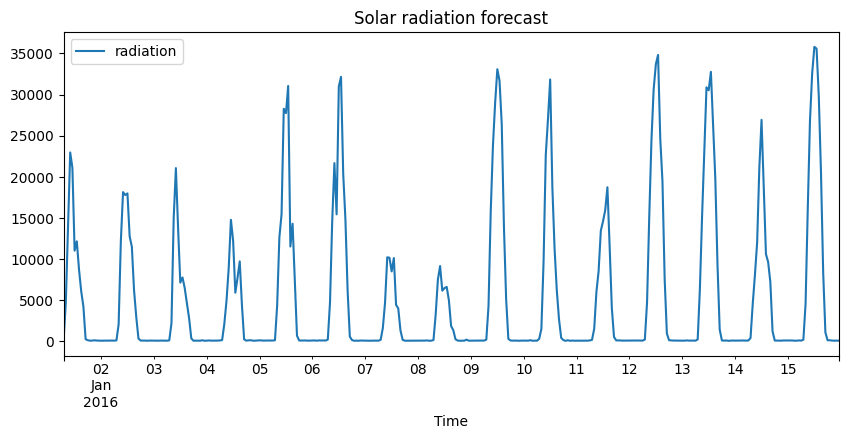

In [33]:
exog_train.plot()
plt.title('Solar radiation forecast')
plt.xlabel('Time');

We add the radiation forecast to the model:

In [34]:
sarimax_pipeline_exog = Pipeline([
    ('arima', pm.AutoARIMA(trace=True, m=24, method='nm', maxiter=10))])

sarimax_pipeline_exog.fit(train_solar,exog_train) # <-- here we input the exogenous variable

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=5321.329, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=5539.434, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=5304.114, Time=0.51 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=5388.144, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=5756.079, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=5302.361, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=5312.354, Time=0.44 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=5312.308, Time=0.75 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=5304.845, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=5304.673, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=5382.866, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[24] intercept   : AIC=5601.509, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[24]             : AIC=5303.945, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[24] intercept
Total fit time: 3.381 seconds


Pipeline(steps=[('arima',
                 AutoARIMA(m=24, maxiter=10, method='nm', trace=True))])

Let's look at the in-sample predictions. Again, note that we need to input the exogenous variable.

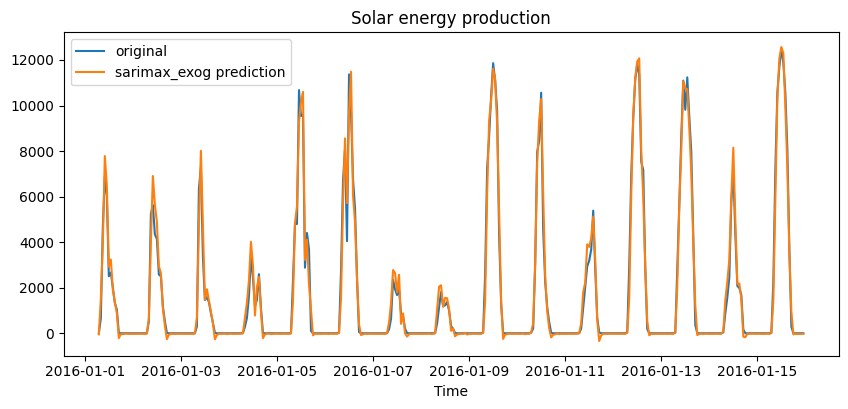

In [35]:
plt.plot(train_solar, label='original')
plt.plot(train_solar.index, sarimax_pipeline_exog.predict_in_sample(exog_train), label='sarimax_exog prediction')
plt.xlabel('Time')
plt.title('Solar energy production')
plt.legend();

In [36]:
mean_absolute_error(sarimax_pipeline_exog.predict_in_sample(exog_train)[1:],train_solar.iloc[1:])

236.9901093506235

We left out just the first point because this model is not seasonal. It captured the variance changes so much better! Notice also that the model is much simpler. It is in fact a regression model with ARMA errors, it does not contain the seasonal component and it's purely autoregressive. The exogenous variable took care of reproducing the seasonality.

What about the multi-step forecast?

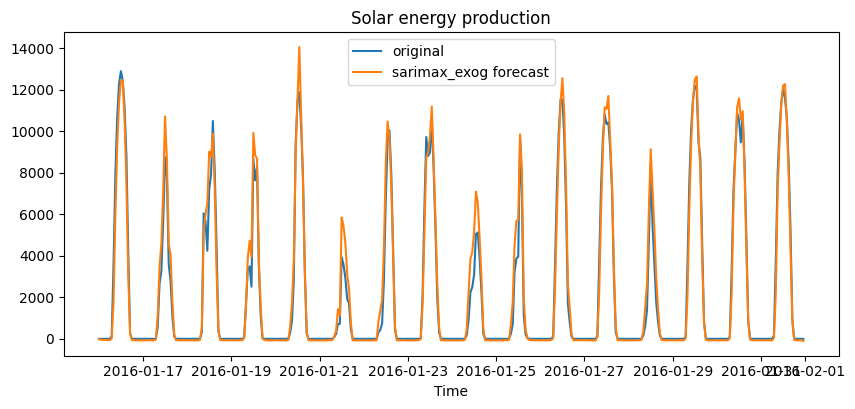

In [37]:
plt.plot(test_solar, label='original')
plt.plot(test_solar.index, sarimax_pipeline_exog.predict(test_solar.shape[0],exog_test), label='sarimax_exog forecast')
plt.xlabel('Time')
plt.title('Solar energy production')
plt.legend();

In [38]:
mean_absolute_error(sarimax_pipeline_exog.predict(test_solar.shape[0],exog_test),test_solar)

373.9264235982414

Looking good! The MAE has dropped by more than two thirds compared to not using the exogenous variable. This is a context where the use of exogenous variables clearly improves performance.

There are many other cases where exogenous variables help. For example, to forecast supermarket sales it might be relevant to take into account temperature forecasts, to forecast wind power we need to take into account wind forecasts, etc.

If you think that this dataset is way too simple for ARIMA and could be fitted just with a linear regression, you are right. In fact, regression models are a special class of time series models and we will see how to use them in the next BLU.

## 3. Confidence Intervals

Have we told you that you can also get confidence intervals for free from the pipeline? Simply use `return_conf_int=True` when getting the forecast:

In [39]:
preds = sarimax_pipeline_exog.predict(test_solar.shape[0],exog_test, return_conf_int=True)

Remember Sam told us to build functions as we go? Let's not write this stuff again.

In [40]:
def plot_predictions(series_, pred_):
    
    mean_predictions_ = pd.Series(pred_[0], index=series_.index)

    pred_ci_ = pd.DataFrame(pred_[1], columns=['lower bound', 'upper bound'],
                           index=series_.index)
    
    series_.plot(label='observed')
    mean_predictions_.plot(label='forecast', 
                           alpha=.7)

    plt.fill_between(pred_ci_.index,
                     pred_ci_['lower bound'],
                     pred_ci_['upper bound'], 
                     color='k', 
                     alpha=.2)

    plt.xlabel('Time')
    plt.title('Solar energy production')
    plt.legend();

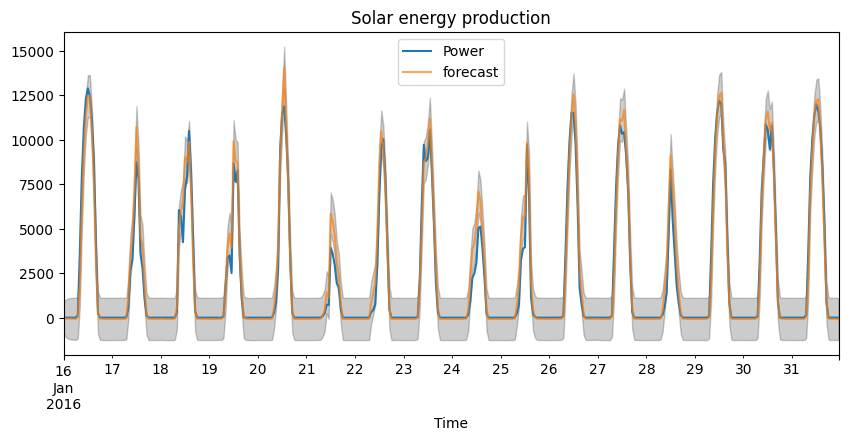

In [41]:
plot_predictions(test_solar, preds)

Confidence intervals can be very useful for business-driven decisions. In most real scenarios we're not only interested in the forecasted value but also in the uncertainty associated to it. The default confidence intervals in pmdarima are 95% which means that 95 times out of 100, the predictions will fall into this interval.

## 4. Further reading

Check out the usage examples in the pmdarima documentation:
- https://alkaline-ml.com/pmdarima/usecases.html
- https://alkaline-ml.com/pmdarima/auto_examples/index.html
- https://alkaline-ml.com/pmdarima/auto_examples/example_pipeline.html#sphx-glr-auto-examples-example-pipeline-py

Auto_arima has its quirks. If you start getting non-sensical or inconsistent results, try setting the `suppress_warnings` parameter to False. It will start showing warnings from statsmodels which is behind pmdarima.

More about endogenous and exogenous variables:
- dictionary definitions of [endogenous](https://www.merriam-webster.com/dictionary/endogenous) and [exogenous](https://www.merriam-webster.com/dictionary/exogenous).
- more definitions from [Statistics How To](https://www.statisticshowto.com/endogenous-variable/) and [Machine Learning Mastery](https://machinelearningmastery.com/taxonomy-of-time-series-forecasting-problems/#:~:text=An%20input%20variable%20is%20endogenous,%2D2%2C%20and%20so%20on).
- the differences between the two variable types on this economics-inspired webpage from [Reed College](https://www.reed.edu/economics/course_pages.archive/red_spots/endogenous_and_exogenous_v.htm) and [Youtube video](https://www.youtube.com/watch?v=qiQhAyuH2P4) from Free Econ Help.

For more about exogenous regressors, see this statsmodels [example](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html#ARIMA-Example-4:-ARMAX-(Friedman)). A very good explanations about different formulations of ARIMA and exogenous regressors can be found on the [hyndsight blog](https://robjhyndman.com/hyndsight/arimax/) (this blog is a treasure trove of information).

Sometimes Fourier exogenous variables can replace seasonality. This is interesting especially for very long seasonalities. See more on the [hyndsight blog](https://robjhyndman.com/hyndsight/longseasonality/).

Here we've been talking mostly about timeseries forecasting, but there are many other machine learning applications related to timeseries: timeseries classification, anomaly detection, change point detection, etc. Confidence intervals are particularly important for anomaly detection. You can imagine that when we measure values that fall considerably out of our forecast bounds, then we may have some abnormal behavior. For a quick intro to timeseries anomaly detection check out this [article](https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/time-series-anomaly-detection).

There are other timeseries models and tools that we didn't talk about. One that deserves special mention is Facebook's [Prophet](https://facebook.github.io/prophet/).

And now, time for the exercises!